# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

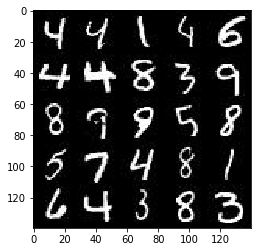

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

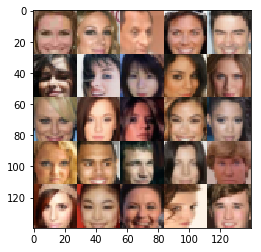

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        #print(relu1.shape)
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        #print(relu2.shape)
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256        
        #print(relu3.shape)
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        #print(flat.shape)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x256 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x128 now
        #print(x2.shape)
        # Output layer
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        #print(x3.shape)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        #print(logits.shape)
        out = tf.tanh(logits)   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
   
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Normalized images from -1 to 1 in helper.py.
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                    learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                    learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3959... Generator Loss: 0.0439
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 0.3720... Generator Loss: 9.1637
Epoch 1/2... Discriminator Loss: 2.2341... Generator Loss: 0.3057
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.2813... Generator Loss: 2.3086
Epoch 1/2... Discriminator Loss: 0.1952... Generator Loss: 2.8782
Epoch 1/2... Discriminator Loss: 0.2604... Generator Loss: 1.8524
Epoch 1/2... Discriminator Loss: 0.1660... Generator Loss: 3.3064
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.0860


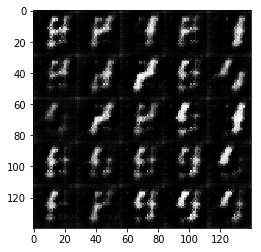

Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 1.3199
Epoch 1/2... Discriminator Loss: 0.9842... Generator Loss: 0.9222
Epoch 1/2... Discriminator Loss: 0.3155... Generator Loss: 1.9486
Epoch 1/2... Discriminator Loss: 0.2045... Generator Loss: 2.1833
Epoch 1/2... Discriminator Loss: 0.2668... Generator Loss: 2.4922
Epoch 1/2... Discriminator Loss: 1.7832... Generator Loss: 7.1409
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 2.1649
Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 1.7909
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 0.9385


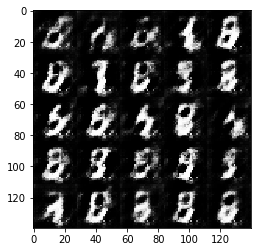

Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 2.7780
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 2.3865
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.0060
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 1.7309
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 1.6601
Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 0.4763... Generator Loss: 2.3286
Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 2.8977


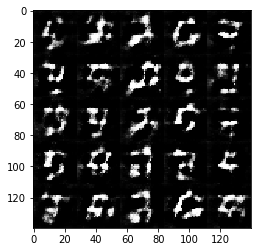

Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 4.0055
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 3.9722
Epoch 1/2... Discriminator Loss: 0.4081... Generator Loss: 1.8943
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 0.3796... Generator Loss: 1.8424
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 1.9902
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 1.0036


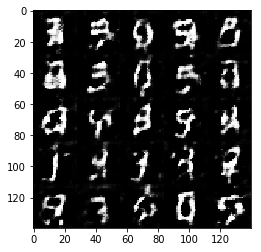

Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.4918
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.3984
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 1.9475
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 2.6052
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 2.0620
Epoch 1/2... Discriminator Loss: 0.7188... Generator Loss: 2.3570
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 1.5869
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.6441
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.0091


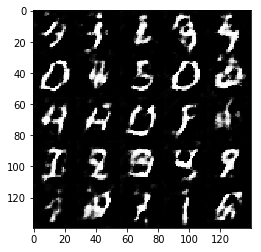

Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 2.4620
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.6396... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.3044
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 1.3222
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 3.2406


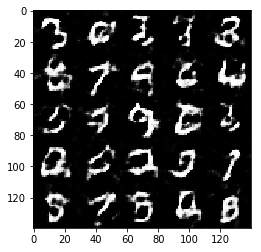

Epoch 1/2... Discriminator Loss: 0.4751... Generator Loss: 2.0457
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 2.8547
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 2.4478
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.8823
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 2.2179
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 2.3316
Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 1.3628
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.4974
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.7593


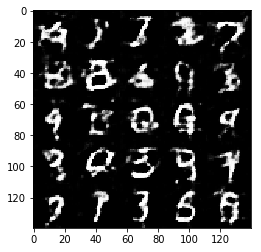

Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 2.3847
Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 1.8073
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 1.5225
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.7039
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 2.0941
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 1.5162
Epoch 1/2... Discriminator Loss: 0.6149... Generator Loss: 2.0699


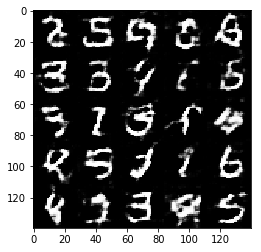

Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.7311
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 0.7449... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.5753


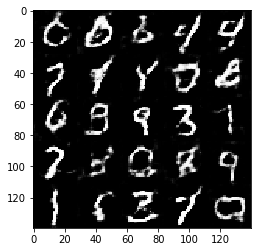

Epoch 1/2... Discriminator Loss: 0.8771... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.6175
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 2.2298
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 2.4168
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.1428


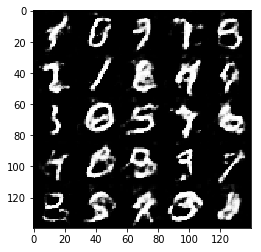

Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 3.0243
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 1.0769
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.4770
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.6203
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 1.5434
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 0.5375... Generator Loss: 1.6078


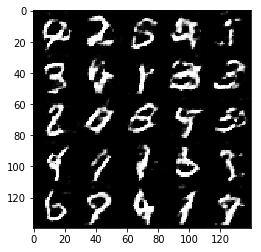

Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.9846
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 2.0776
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 2.7100... Generator Loss: 0.1146
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6787


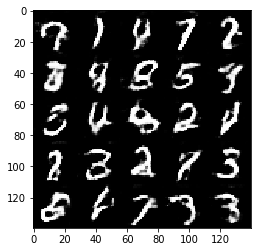

Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.2035
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 2.7454
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.8336


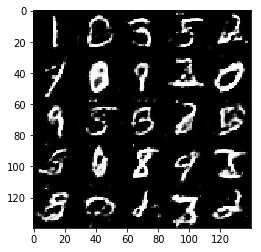

Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.3127
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 1.7941
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 0.3915... Generator Loss: 1.8234
Epoch 2/2... Discriminator Loss: 0.6768... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 2.7954... Generator Loss: 0.1154
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 1.9276
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.7652


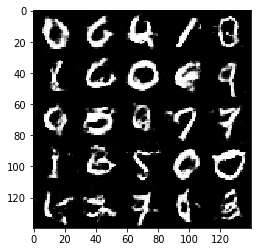

Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.4003
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.4130
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 0.8377


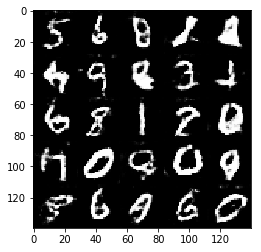

Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 1.8295
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 4.3405
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.4704
Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.3715


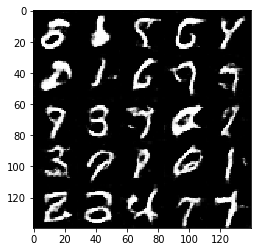

Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 2.2886
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 1.3592
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 1.7237... Generator Loss: 0.2693
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.4214


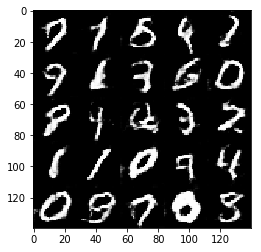

Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 1.7256
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 0.3532... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 1.7982... Generator Loss: 0.2423
Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.5144... Generator Loss: 2.0111
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 2.6284
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.6211


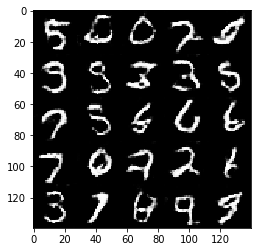

Epoch 2/2... Discriminator Loss: 0.6379... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 0.4493... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 0.9749
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 0.9754


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 5.6203
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 7.0188
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 1.8566... Generator Loss: 11.5798
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.4755
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 4.8348
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 2.6269


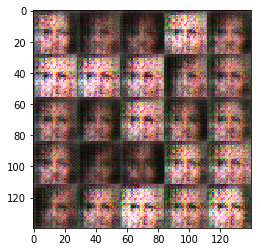

Epoch 1/1... Discriminator Loss: 0.3090... Generator Loss: 3.9684
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 2.7139
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 3.9129
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 4.3972
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 2.8530
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.9862
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 2.6044
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.0846


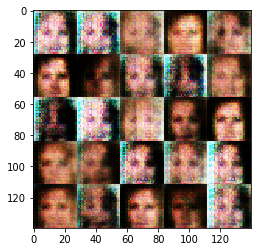

Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 4.2933
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 3.5841
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 3.4666
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.3278


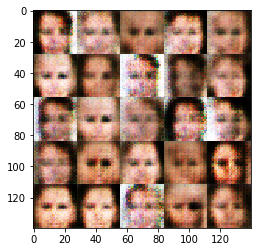

Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.3061
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.5143
Epoch 1/1... Discriminator Loss: 2.4346... Generator Loss: 4.9151
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.9179
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 3.1971... Generator Loss: 4.8145
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.6798


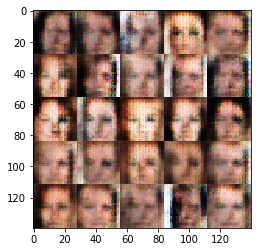

Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 2.2864
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 2.7937
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.8259
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6927


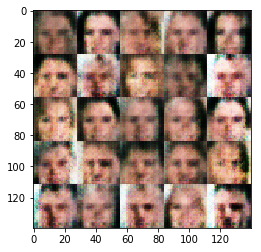

Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.9374
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 2.1390
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.3746


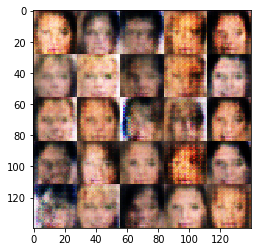

Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 2.8720
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.2064


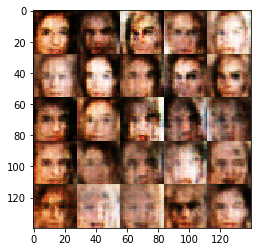

Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.9756
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.8411
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 2.3396... Generator Loss: 0.1795


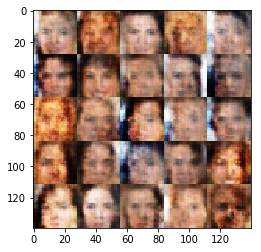

Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.5890


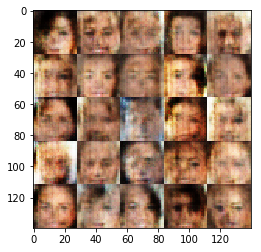

Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 2.0292
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 2.2630
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.1105


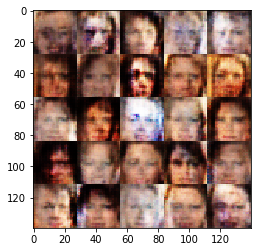

Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.7714
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.9743
Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.3896


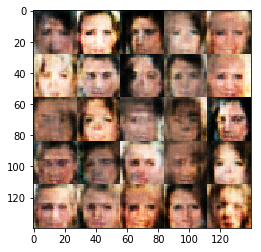

Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 3.2103
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.7610
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.3579
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.8512
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.8606


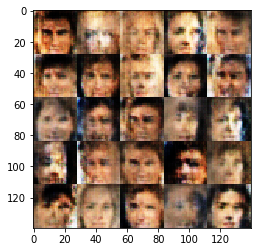

Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.9655


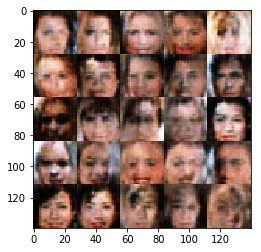

Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.7474
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 2.3826
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 2.2424


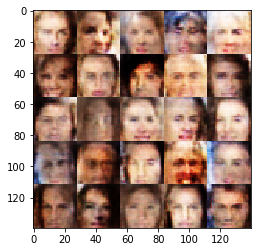

Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.2175


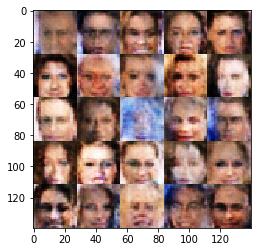

Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.6005
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.2499


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.